# E3 long long epoch
---

## Environment Setting
---

In [41]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

import math
import numpy as np
import tensorflow as tf
import keras
import h5py
from pathlib import Path

import matplotlib.pyplot as plt
import cv2
import math
from tqdm import tqdm

%env SM_FRAMEWORK=tf.keras
import segmentation_models as sm
import albumentations as A

import seaborn
seaborn.set(style='white')
seaborn.set_context('paper')

env: SM_FRAMEWORK=tf.keras


In [2]:
import tensorflow as tf
def init_gpu():
    gpus = tf.config.experimental.list_physical_devices('GPU')
    if gpus:
        try:
            # Currently, memory growth needs to be the same across GPUs
            for gpu in gpus:
                tf.config.experimental.set_memory_growth(gpu, True)
            logical_gpus = tf.config.experimental.list_logical_devices('GPU')

            print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs\n\n")
        except RuntimeError as e:
            # Memory growth must be set before GPUs have been initialized
            print(e, "\n\n")

init_gpu()

1 Physical GPUs, 1 Logical GPUs




In [5]:
!pwd

/workspace/Model/E3


In [3]:
FILE_PATH = '/workspace/Model/data/LV1_PNG_DATASET_B.h5'
BASE_TARIN_DIR = "/train"
TRAIN_IMG_PATH = f'{Path(BASE_TARIN_DIR)}/img'
TRAIN_LABEL_PATH = f'{Path(BASE_TARIN_DIR)}/label'
TRAIN_SPLIT_DIR = f'{Path(BASE_TARIN_DIR)}/split'  
TRAIN_SPLIT_IMG_PATH = f'{Path(BASE_TARIN_DIR)}/split/img'           
TRAIN_SPLIT_LABEL_PATH = f'{Path(BASE_TARIN_DIR)}/split/label'                                                                                                                         

BASE_VAL_DIR = "/val"
VAL_IMG_PATH = f'{Path(BASE_VAL_DIR)}/img'
VAL_LABEL_PATH = f'{Path(BASE_VAL_DIR)}/label'
VAL_SPLIT_DIR = f'{Path(BASE_VAL_DIR)}/split'  
VAL_SPLIT_IMG_PATH = f'{Path(BASE_VAL_DIR)}/split/img'           
VAL_SPLIT_LABEL_PATH = f'{Path(BASE_VAL_DIR)}/split/label'  

BASE_TEST_DIR = "/test"
TEST_IMG_PATH = f'{Path(BASE_TEST_DIR)}/img'
TEST_LABEL_PATH = f'{Path(BASE_TEST_DIR)}/label'
TEST_SPLIT_DIR = f'{Path(BASE_TEST_DIR)}/split'  
TEST_SPLIT_IMG_PATH = f'{Path(BASE_TEST_DIR)}/split/img'           
TEST_SPLIT_LABEL_PATH = f'{Path(BASE_TEST_DIR)}/split/label'  

IMAGE_SIZE = 1024
IMG_CHANNELS = 3

COLOR_MAP = [
    (165, 42, 42),
    (0, 192, 0),
    (255,255,255)
]

### dataset 확인

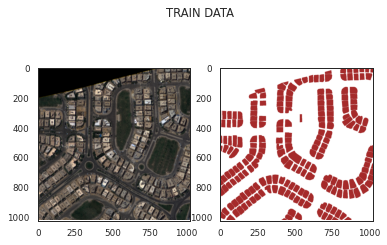

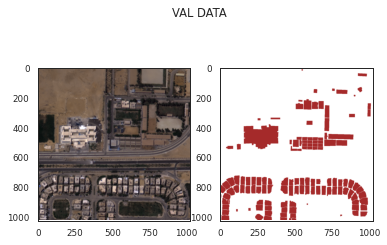

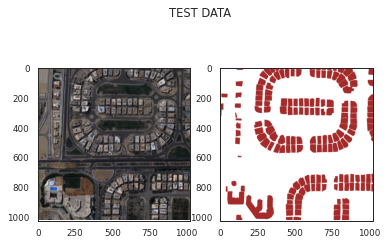

In [7]:
import matplotlib.pyplot as plt
i = 0

with h5py.File(FILE_PATH, 'r') as hdf5_file:
    plt.suptitle('TRAIN DATA')
    plt.subplot(121)
    plt.imshow(hdf5_file[TRAIN_IMG_PATH][i])
    plt.subplot(122)
    plt.imshow(hdf5_file[TRAIN_LABEL_PATH][i])
    plt.show()
    
    plt.suptitle('VAL DATA')
    plt.subplot(121)
    plt.imshow(hdf5_file[VAL_IMG_PATH][i])
    plt.subplot(122)
    plt.imshow(hdf5_file[VAL_LABEL_PATH][i])
    plt.show()
    
    plt.suptitle('TEST DATA')
    plt.subplot(121)
    plt.imshow(hdf5_file[TEST_IMG_PATH][i])
    plt.subplot(122)
    plt.imshow(hdf5_file[TEST_LABEL_PATH][i])
    plt.show()

## Split and Save image
---

### 함수정의

In [4]:
def get_slice_pos(split_cnt, STRIDE_SIZE, INPUT_SIZE):
    pts = []
    n = math.sqrt(split_cnt)
    for slice_pos in range(split_cnt):
        pos_i = int(math.floor(slice_pos / n))
        pos_j = int(slice_pos % int(n))
        x = STRIDE_SIZE * pos_i
        y = STRIDE_SIZE * pos_j
        pts.append((x, x+INPUT_SIZE, y, y+INPUT_SIZE))
    return pts

In [5]:
def split_png(img, pts):
    if len(img.shape) == 3:
        sub_imgs = [img[x0:x1, y0:y1, :] for x0, x1, y0, y1 in pts]
    elif len(img.shape) == 2:
        sub_imgs = [img[x0:x1, y0:y1] for x0, x1, y0, y1 in pts]
    return sub_imgs

In [6]:
def save_png_imgs_labels(dataset, i, imgs, labels):
    for img, label in zip(imgs, labels):
        dataset['img'][i, ...] = img
        dataset['label'][i, ...] = label
        i += 1
    return i

### Split

In [7]:
STRIDE_SIZE = 192
INPUT_SIZE = 256
SPLIT_CNT = 25
pts = get_slice_pos(SPLIT_CNT, STRIDE_SIZE, INPUT_SIZE)

In [8]:
def split_and_save(FILE_PATH, BASE_DIR, IMG_PATH, LABEL_PATH, SPLIT_DIR, COLOR, pts, img_size=256, split_cnt=25):
    with h5py.File(FILE_PATH, "a") as f:
        size = f[IMG_PATH].shape[0] * split_cnt
        if 'split' in f[BASE_DIR].keys(): del f[SPLIT_DIR]
        f[BASE_DIR].create_group('split')
        f[BASE_DIR]['split'].create_dataset('img', (size, img_size, img_size, 3), np.uint8)
        f[BASE_DIR]['split'].create_dataset('label', (size, img_size, img_size), np.float32)
        
        sub_idx = 0
        for i in tqdm(range(f[IMG_PATH].shape[0])):
            sub_imgs = split_png(f[IMG_PATH][i], pts)

            mask = (f[LABEL_PATH][i] == COLOR)
            mask = (mask[:,:,0] +  mask[:,:,1] +  mask[:,:,2]).astype(np.float32)
            sub_labels = split_png(mask, pts)

            sub_idx = save_png_imgs_labels(f[SPLIT_DIR], sub_idx, sub_imgs, sub_labels)

In [12]:
split_and_save(FILE_PATH, BASE_TARIN_DIR, TRAIN_IMG_PATH, TRAIN_LABEL_PATH,
               TRAIN_SPLIT_DIR, COLOR_MAP[0], pts)

split_and_save(FILE_PATH, BASE_VAL_DIR, VAL_IMG_PATH, VAL_LABEL_PATH,
               VAL_SPLIT_DIR, COLOR_MAP[0], pts)

split_and_save(FILE_PATH, BASE_TEST_DIR, TEST_IMG_PATH, TEST_LABEL_PATH,
               TEST_SPLIT_DIR, COLOR_MAP[0], pts)

100%|██████████| 159/159 [00:05<00:00, 26.71it/s]


### Sample

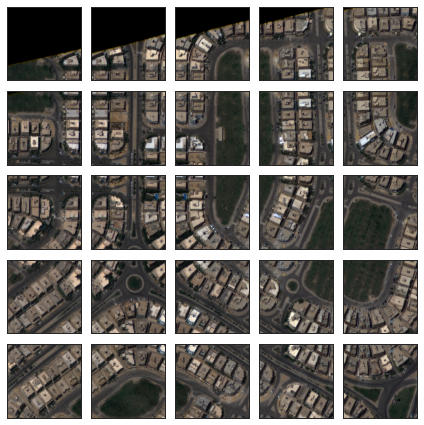

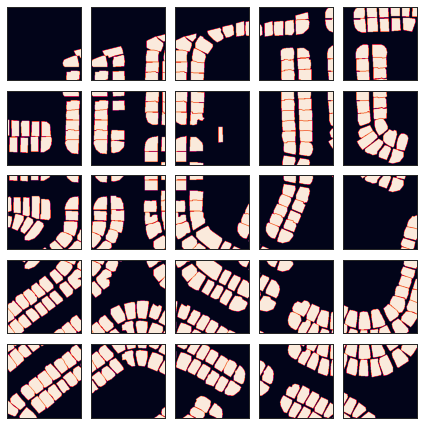

In [13]:
with h5py.File(FILE_PATH, "a") as f:
    idx = 0
    imgs = f[TRAIN_SPLIT_IMG_PATH][idx*25:idx*25+25]
    plt.figure(figsize=(6, 6))
    for i, sub_img in enumerate(imgs):
        plt.subplot(5, 5, i+1)
        ax = plt.gca()
        ax.axes.xaxis.set_visible(False)
        ax.axes.yaxis.set_visible(False)
        plt.imshow(sub_img)
            
    plt.tight_layout()
    plt.show()
    
    masks = f[TRAIN_SPLIT_LABEL_PATH][idx*25:idx*25+25]
    plt.figure(figsize=(6, 6))
    for i, sub_img in enumerate(masks):
        plt.subplot(5, 5, i+1)
        ax = plt.gca()
        ax.axes.xaxis.set_visible(False)
        ax.axes.yaxis.set_visible(False)
        plt.imshow(sub_img)
            
    plt.tight_layout()
    plt.show()

## Dataloader and utility functions
---

In [14]:
def visualize(**images):
    """PLot images in one row."""
    n = len(images)
    fig, axs = plt.subplots(1, n, figsize=(10, 5))
    
    for i, (name, image) in enumerate(images.items()):
        axs[i].set_xticks([])
        axs[i].set_yticks([])
        axs[i].set_title(' '.join(name.split('_')).title())
        axs[i].imshow(image)
        
    plt.tight_layout()
    plt.show()

In [15]:
# helper function for data visualization    
def denormalize(x):
    """Scale image to range 0..1 for correct plot"""
    x_max = np.percentile(x, 98)
    x_min = np.percentile(x, 2)    
    x = (x - x_min) / (x_max - x_min)
    x = x.clip(0, 1)
    return x

In [16]:
def round_clip_0_1(x, **kwargs):
    return x.round().clip(0, 1)

def get_training_augmentation():
    train_transform = [
        A.RandomRotate90(p=0.5),
        A.RandomRotate90(p=0.5),
        A.RandomRotate90(p=0.5),
        A.Lambda(mask=round_clip_0_1)
    ]
    return A.Compose(train_transform)


def get_validation_augmentation():
    """Add paddings to make image shape divisible by 32"""
    test_transform = [
        A.Lambda(mask=round_clip_0_1)
    ]
    return A.Compose(test_transform)

def get_preprocessing(preprocessing_fn):
    """Construct preprocessing transform
    
    Args:
        preprocessing_fn (callbale): data normalization function 
            (can be specific for each pretrained neural network)
    Return:
        transform: albumentations.Compose
    
    """
    _transform = [
        A.CLAHE(clip_limit=2.0, tile_grid_size=(16, 16), p=1),
        A.Lambda(image=preprocessing_fn),
    ]
    return A.Compose(_transform)

In [17]:
class SatelliteGenerator(tf.keras.utils.Sequence):
    '''
    ref: https://github.com/AIFFEL-FREESIA/Model/blob/master/Unet_building_256_2.ipynb
    SatelliteGenerator는 tf.keras.utils.Sequence를 상속받습니다.
    '''
    def __init__(self, 
                 filepath,
                 x_path,
                 y_path,
                 batch_size=8,
                 augmentation=None, 
                 preprocessing=None,
                 is_train=True):
        
        self.filepath = filepath
        self.x_path = x_path
        self.y_path = y_path
        
        self.augmentation = augmentation
        self.preprocessing = preprocessing

        self.size = 0
        with h5py.File(self.filepath, 'r') as f:
            self.size = f[x_path].shape[0]
            
        self.batch_size = batch_size
        self.is_train = is_train
    
    def __len__(self):
        return math.ceil(self.size / self.batch_size)

    def __getitem__(self, index):
        with h5py.File(self.filepath, 'r') as f:
            images = f[self.x_path][index*self.batch_size : (index + 1)*self.batch_size]
            masks = f[self.y_path][index*self.batch_size : (index + 1)*self.batch_size]
            res = [(img, mask) for img, mask in zip(images, masks)]

            if self.augmentation:
                res = [self.augmentation(image=img, mask=mask) for img, mask in res]
                res = [(r['image'], r['mask']) for r in res]
            if self.preprocessing:
                res = [self.preprocessing(image=img, mask=mask) for img, mask in res]
                res = [(r['image'], r['mask']) for r in res]
            
            images = np.array([img for img, _ in res ])
            masks = np.array([mask for _, mask in res ])
            
            return images, masks

    def on_epoch_end(self):
        # 한 epoch가 끝나면 실행되는 함수입니다. 학습중인 경우에 순서를 random shuffle하도록 적용한 것을 볼 수 있습니다.
        self.indexes = np.arange(self.size)
        if self.is_train == True :
            np.random.shuffle(self.indexes)
        
        return self.indexes

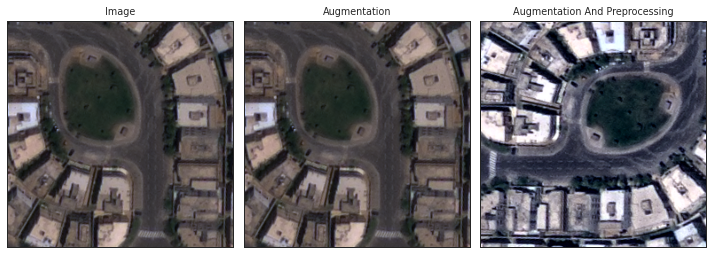

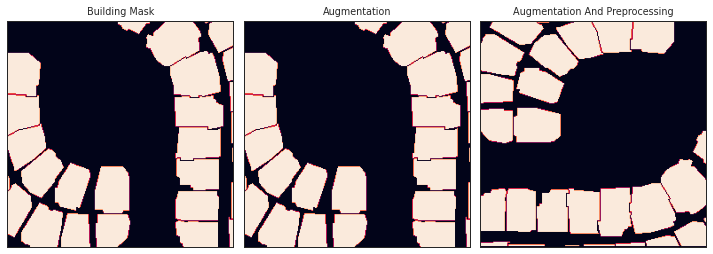

In [26]:
# Lets look at augmented data we have
dataset = SatelliteGenerator(
    FILE_PATH,
    TRAIN_SPLIT_IMG_PATH,
    TRAIN_SPLIT_LABEL_PATH, 
    augmentation=get_training_augmentation()
)

dataset_aug = SatelliteGenerator(
    FILE_PATH,
    TRAIN_SPLIT_IMG_PATH,
    TRAIN_SPLIT_LABEL_PATH, 
    augmentation=get_training_augmentation())

preprocess_input = sm.get_preprocessing('efficientnetb3')
dataset_aug_pre = SatelliteGenerator(
    FILE_PATH,
    TRAIN_SPLIT_IMG_PATH,
    TRAIN_SPLIT_LABEL_PATH,
    augmentation=get_training_augmentation(),
    preprocessing=get_preprocessing(preprocess_input)
)

idx = 10
image, mask = dataset[idx] # get some sample
image_aug, mask_aug = dataset_aug[idx]
image_aug_pre, mask_aug_pre = dataset_aug_pre[idx]


visualize(
    image=image[0], 
    augmentation=image_aug[0],
    augmentation_and_preprocessing=denormalize(image_aug_pre[0])
)

visualize(
    building_mask=mask[0],
    augmentation=mask_aug[0],
    augmentation_and_preprocessing=mask_aug_pre[0]
)

# Train Model

### functions

In [18]:
def get_datagenerator(BATCH_SIZE=8, BACKBONE='efficientnetb3'):
    # Dataset for train images
    preprocess_input = sm.get_preprocessing(BACKBONE)
    train_datagenerator = SatelliteGenerator(
        FILE_PATH,
        TRAIN_SPLIT_IMG_PATH,
        TRAIN_SPLIT_LABEL_PATH,
        batch_size=BATCH_SIZE,
        augmentation=get_training_augmentation(),
        preprocessing=get_preprocessing(preprocess_input),
        is_train=True
    )

    # Dataset for validation image
    valid_datagenerator = SatelliteGenerator(
        FILE_PATH,
        VAL_SPLIT_IMG_PATH, 
        VAL_SPLIT_LABEL_PATH, 
        batch_size=BATCH_SIZE,
        augmentation=get_validation_augmentation(),
        preprocessing=get_preprocessing(preprocess_input),
        is_train=False
    )

    return train_datagenerator, valid_datagenerator

In [19]:
import time
import datetime
def logging_time(original_fn):
    def wrapper_fn(*args, **kwargs):
        start_time = time.time()
        
        result = original_fn(*args, **kwargs)
        
        sec = time.time()-start_time
        times = str(datetime.timedelta(seconds=sec)).split(".")
        times = times[0]
        print(f'WorkingTime : {times}')
        return result
    return wrapper_fn

In [20]:
def get_cosine_lr(initial_learning_rate, t_period, lr_min=0.):
    return tf.keras.experimental.CosineDecay(
        initial_learning_rate=initial_learning_rate,
        decay_steps=t_period, alpha=lr_min / initial_learning_rate)

In [33]:
def get_model(model_name, optim, train, valid, MODEL_PATH, patience=5):
    BACKBONE = 'efficientnetb3'
    CLASSES = ['building']

    # define network parameters
    n_classes = 1 if len(CLASSES) == 1 else (len(CLASSES) + 1)  # case for binary and multiclass segmentation
    activation = 'sigmoid' if n_classes == 1 else 'softmax'

    #create model
    tf.random.set_seed(2)
    model = sm.Unet(BACKBONE, 
                    classes=n_classes, 
                    activation=activation,
                    encoder_weights='imagenet')

    # Segmentation models losses can be combined together by '+' and scaled by integer or float factor
    dice_loss = sm.losses.DiceLoss()
    focal_loss = sm.losses.BinaryFocalLoss() if n_classes == 1 else sm.losses.CategoricalFocalLoss()
    total_loss = dice_loss + (1 * focal_loss)
    metrics = [sm.metrics.IOUScore(threshold=0.5), sm.metrics.FScore(threshold=0.5)]

    # compile keras model with defined optimozer, loss and metrics
    model.compile(optim, total_loss, metrics)
    
    log_dir = f"./logs/fit/{model_name}"
    tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
    callbacks = [
        keras.callbacks.ModelCheckpoint(MODEL_PATH, save_weights_only=True, save_best_only=True, mode='min', monitor='val_loss'),
        keras.callbacks.ReduceLROnPlateau(verbose=1),
        tensorboard_callback,
#         keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=patience)
    ]
    
    return model, callbacks

In [23]:
def show_history_plot(history):
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    keys = [('loss', 'val_loss'), ('iou_score', 'val_iou_score'), ('f1-score', 'val_f1-score')]
    
    for (train, val), ax in zip(keys, axes):
        ax.plot(history[train])
        ax.plot(history[val])
        ax.set_title(f'Model {train}')
        ax.set_ylabel(train)
        ax.set_xlabel('Epoch')
        ax.legend(['Train', 'Validation'], loc='upper left')

    plt.tight_layout()
    plt.show()

In [24]:
def inference(model, img, pts):
    preprocessing = A.Compose([
        A.CLAHE(clip_limit=2.0, tile_grid_size=(16, 16), p=1),
        A.Lambda(image=sm.get_preprocessing(BACKBONE)),
    ])

    sub_imgs = split_png(img, pts)
    sub_imgs = [preprocessing(image=img)['image'] for img in sub_imgs]
#     show_spiltd_img(sub_imgs, denor=True)

    sub_imgs = [np.expand_dims(img, axis=0) for img in sub_imgs]
    pre_imgs = [model.predict(img) for img in sub_imgs]
    pre_imgs = [pre[..., 0].squeeze() for pre in pre_imgs]
    pre_imgs = [pre.round().clip(0, 1) for pre in pre_imgs]
#     show_spiltd_img(pre_imgs)
    
    merged = np.zeros((1024, 1024))
    for i, (x0, x1, y0, y1) in enumerate(pts) : 
        sub = (merged[x0:x1, y0:y1] + pre_imgs[i])/2
        sub = np.where(sub - sub//1 > 0, sub+0.00001, sub)
        sub = np.round(sub)
        merged[x0:x1, y0:y1] = sub
    return merged

In [47]:
def show_inference(model, pts):
    with h5py.File(FILE_PATH, "r") as f:
        for idx in range(5):
            img = f[TEST_IMG_PATH][idx]
            mask = (f[TEST_LABEL_PATH][idx] == COLOR_MAP[0])
            mask = (mask[:,:,0] +  mask[:,:,1] +  mask[:,:,2]).astype(np.float32)


            predicted = inference(model, img, pts)
            images = {'Image': img, 
                      'Ground Truth': mask,
                      'Prediction': predicted}

            visualize(
                image=img,
                ground_truth=mask,
                predicted=predicted
            )

### E3-final

#### 모델 정의

In [32]:
lr = 1e-4
BATCH_SIZE = 32
EPOCHS=100
optim = keras.optimizers.Adam(lr=lr)
train_datagenerator, valid_datagenerator = get_datagenerator(BATCH_SIZE=BATCH_SIZE)

In [35]:
model, callbacks = get_model(
    'E3-final',
    optim,
    train_datagenerator, 
    valid_datagenerator,
    '/workspace/Model/trained_model/E3/E3_final.h5')

In [36]:
start_time = time.time()

history = model.fit(
    train_datagenerator, 
    steps_per_epoch=len(train_datagenerator), 
    epochs=EPOCHS, 
    callbacks=callbacks, 
    validation_data=valid_datagenerator, 
    validation_steps=len(valid_datagenerator))

sec = time.time()-start_time
times = str(datetime.timedelta(seconds=sec)).split(".")
times = times[0]
print(f'WorkingTime : {times}')

Epoch 1/100
850/850 [==============================] - 588s 517ms/step - loss: 0.6913 - iou_score: 0.3674 - f1-score: 0.5073 - val_loss: 0.4505 - val_iou_score: 0.5660 - val_f1-score: 0.7060
Epoch 2/100
850/850 [==============================] - 381s 448ms/step - loss: 0.4493 - iou_score: 0.5613 - f1-score: 0.7035 - val_loss: 0.3882 - val_iou_score: 0.6066 - val_f1-score: 0.7414
Epoch 3/100
850/850 [==============================] - 380s 447ms/step - loss: 0.3586 - iou_score: 0.6151 - f1-score: 0.7487 - val_loss: 0.3680 - val_iou_score: 0.5884 - val_f1-score: 0.7192
Epoch 4/100
850/850 [==============================] - 380s 447ms/step - loss: 0.3182 - iou_score: 0.6445 - f1-score: 0.7726 - val_loss: 0.3521 - val_iou_score: 0.6152 - val_f1-score: 0.7440
Epoch 5/100
850/850 [==============================] - 380s 447ms/step - loss: 0.2950 - iou_score: 0.6600 - f1-score: 0.7865 - val_loss: 0.3422 - val_iou_score: 0.6124 - val_f1-score: 0.7421
Epoch 6/100
850/850 [========================

Epoch 45/100
850/850 [==============================] - 380s 447ms/step - loss: 0.1671 - iou_score: 0.7896 - f1-score: 0.8787 - val_loss: 0.3153 - val_iou_score: 0.6513 - val_f1-score: 0.7716
Epoch 46/100
850/850 [==============================] - 380s 447ms/step - loss: 0.1567 - iou_score: 0.8024 - f1-score: 0.8883 - val_loss: 0.3011 - val_iou_score: 0.6539 - val_f1-score: 0.7732
Epoch 47/100
850/850 [==============================] - 380s 447ms/step - loss: 0.1545 - iou_score: 0.8037 - f1-score: 0.8891 - val_loss: 0.2969 - val_iou_score: 0.6530 - val_f1-score: 0.7726
Epoch 48/100
850/850 [==============================] - 381s 448ms/step - loss: 0.1549 - iou_score: 0.8020 - f1-score: 0.8879 - val_loss: 0.2908 - val_iou_score: 0.6626 - val_f1-score: 0.7814
Epoch 49/100
850/850 [==============================] - 379s 446ms/step - loss: 0.1597 - iou_score: 0.7998 - f1-score: 0.8869 - val_loss: 0.3023 - val_iou_score: 0.6443 - val_f1-score: 0.7661
Epoch 50/100
850/850 [==================

KeyboardInterrupt: 

#### evaluation

In [40]:
preprocess_input = sm.get_preprocessing('efficientnetb3')
test_datagenerator = SatelliteGenerator(
    FILE_PATH,
    TEST_SPLIT_IMG_PATH, 
    TEST_SPLIT_LABEL_PATH, 
    batch_size=BATCH_SIZE,
    augmentation=get_validation_augmentation(),
    preprocessing=get_preprocessing(preprocess_input),
    is_train=False
)

val_metrix = model.evaluate(valid_datagenerator)
test_metrix = model.evaluate(test_datagenerator)

125/125 [==============================] - 12s 98ms/step - loss: 0.2795 - iou_score: 0.6926 - f1-score: 0.8040


In [ ]:
BACKBONE = 'efficientnetb3'
show_inference(model, pts)

### E3-6-9 Retrain

In [42]:
lr = 1e-4
BATCH_SIZE = 32
EPOCHS=100
optim = keras.optimizers.Adam(lr=lr)
train_datagenerator, valid_datagenerator = get_datagenerator(BATCH_SIZE=BATCH_SIZE)

In [45]:
model_3_6_9, callbacks = get_model(
    'E3-6-9-retrain',
    optim,
    train_datagenerator, 
    valid_datagenerator,
    '/workspace/Model/trained_model/E3/E3_6_9_retrain.h5')

In [46]:
model_3_6_9.load_weights('/workspace/Model/trained_model/E3/E3_6_9_best_model.h5')

In [48]:
start_time = time.time()

history = model_3_6_9.fit(
    train_datagenerator, 
    steps_per_epoch=len(train_datagenerator), 
    epochs=EPOCHS, 
    callbacks=callbacks, 
    validation_data=valid_datagenerator, 
    validation_steps=len(valid_datagenerator))

sec = time.time()-start_time
times = str(datetime.timedelta(seconds=sec)).split(".")
times = times[0]
print(f'WorkingTime : {times}')

Epoch 1/100
850/850 [==============================] - 397s 451ms/step - loss: 0.2499 - iou_score: 0.7038 - f1-score: 0.8131 - val_loss: 0.2465 - val_iou_score: 0.7131 - val_f1-score: 0.8233
Epoch 2/100
850/850 [==============================] - 381s 448ms/step - loss: 0.2471 - iou_score: 0.7035 - f1-score: 0.8154 - val_loss: 0.2565 - val_iou_score: 0.6839 - val_f1-score: 0.8009
Epoch 3/100
850/850 [==============================] - 381s 449ms/step - loss: 0.2257 - iou_score: 0.7246 - f1-score: 0.8330 - val_loss: 0.2459 - val_iou_score: 0.7053 - val_f1-score: 0.8141
Epoch 4/100
850/850 [==============================] - 381s 448ms/step - loss: 0.2181 - iou_score: 0.7331 - f1-score: 0.8397 - val_loss: 0.2512 - val_iou_score: 0.6965 - val_f1-score: 0.8113
Epoch 5/100
850/850 [==============================] - 380s 448ms/step - loss: 0.2276 - iou_score: 0.7262 - f1-score: 0.8330 - val_loss: 0.2527 - val_iou_score: 0.7032 - val_f1-score: 0.8144
Epoch 6/100
850/850 [========================

Epoch 45/100
850/850 [==============================] - 380s 447ms/step - loss: 0.1729 - iou_score: 0.7833 - f1-score: 0.8747 - val_loss: 0.2465 - val_iou_score: 0.7007 - val_f1-score: 0.8099
Epoch 46/100
850/850 [==============================] - 380s 447ms/step - loss: 0.1707 - iou_score: 0.7853 - f1-score: 0.8775 - val_loss: 0.2493 - val_iou_score: 0.6965 - val_f1-score: 0.8071
Epoch 47/100
850/850 [==============================] - 379s 446ms/step - loss: 0.1719 - iou_score: 0.7843 - f1-score: 0.8766 - val_loss: 0.2485 - val_iou_score: 0.6980 - val_f1-score: 0.8081
Epoch 48/100
850/850 [==============================] - 381s 448ms/step - loss: 0.1696 - iou_score: 0.7852 - f1-score: 0.8773 - val_loss: 0.2465 - val_iou_score: 0.7007 - val_f1-score: 0.8098
Epoch 49/100
850/850 [==============================] - 381s 448ms/step - loss: 0.1714 - iou_score: 0.7835 - f1-score: 0.8760 - val_loss: 0.2460 - val_iou_score: 0.7015 - val_f1-score: 0.8103
Epoch 50/100
850/850 [==================

Epoch 87/100
850/850 [==============================] - 382s 449ms/step - loss: 0.1672 - iou_score: 0.7889 - f1-score: 0.8787 - val_loss: 0.2489 - val_iou_score: 0.6974 - val_f1-score: 0.8074
Epoch 88/100
850/850 [==============================] - 381s 449ms/step - loss: 0.1716 - iou_score: 0.7837 - f1-score: 0.8763 - val_loss: 0.2495 - val_iou_score: 0.6966 - val_f1-score: 0.8068
Epoch 89/100
850/850 [==============================] - 382s 449ms/step - loss: 0.1688 - iou_score: 0.7883 - f1-score: 0.8791 - val_loss: 0.2495 - val_iou_score: 0.6957 - val_f1-score: 0.8067
Epoch 90/100
850/850 [==============================] - 381s 448ms/step - loss: 0.1651 - iou_score: 0.7922 - f1-score: 0.8816 - val_loss: 0.2471 - val_iou_score: 0.6997 - val_f1-score: 0.8091
Epoch 91/100
850/850 [==============================] - 385s 453ms/step - loss: 0.1681 - iou_score: 0.7883 - f1-score: 0.8798 - val_loss: 0.2464 - val_iou_score: 0.7010 - val_f1-score: 0.8100
Epoch 92/100
850/850 [==================